In [4]:
from os import walk
import os
import subprocess
import sys
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import time
import json
import re
import urllib2
import unicodedata
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

wordnet_tags = ['n', 'v', 'a', 's', 'r']
%matplotlib inline


# The main code, built from testing, is in the cell immediately below. 

In [43]:
# from http://brandonrose.org/clustering



from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()
wordnet_tags = ['n', 'v', 'a', 's', 'r']

def tokenize_and_stem_n_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    lems = [lemmer.lemmatize(l) for l in filtered_tokens]
    
    return stems,lems
    

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [44]:
path        = os.path.abspath(os.getcwd())
TESTDIR     = os.path.normpath(os.path.join(os.path.expanduser("~"),"projects","LC3-Creations", "examples","KDDsample"))

corpus = {}

start_time = time.time()
for dirName, subdirList, fileList in walk(TESTDIR):
        for fileName in fileList:
            if fileName.startswith('p') and fileName.endswith('.pdf'):
                a = unicode(subprocess.check_output(['pdf2txt.py',str(os.path.normpath(os.path.join(TESTDIR,fileName)))]),errors='ignore')
                document = unicodedata.normalize('NFKD', a).encode('ascii','ignore')
                # Getting title
                title = re.findall("^[^\\n\\n]+",document)[0]
                
                # Getting the abstract
                abstract = re.findall (r'\n\n(Abstract|ABSTRACT)([^]]*)\n\n',document[:2000])[0]
                if isinstance(abstract, tuple):
                    abstract = re.sub('[\s]'," ",abstract[1])
                else:
                    abstract = re.sub('[\s]'," ",abstract)
                    
                # Extracts section with names and email addresses only
                section  = re.findall (r'\n\n([^]]*)\n\n(Abstract|ABSTRACT)',document[:2000])

                type(section[0][0])

                if isinstance(section, list):
                    section = re.sub('[\s]'," ",section[0][0])
                else:
                    section = re.sub('[\s]'," ",section)
                section

                # Code to extract entities from top section of pdf and store a relationship tree
                tagged = nltk.pos_tag(nltk.word_tokenize(section))
                entities = nltk.chunk.ne_chunk(tagged)
                
                # Another entity extractor
                st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
					   encoding='utf-8')
                tokenized_text = word_tokenize(section)
                stanentities = st.tag(tokenized_text)
                
                # Calls function to lemmatize and stem the document; stores the result
                tokenize_and_stem_n_lem(abstract);

                
                # Creates the json document format to store the files
                corpus[str(fileName)]={}
                corpus[str(fileName)]={'Title':title,'Abstract':abstract,'Entities':entities, 
                                       "Stanford ER":stanentities, "Stems": tokenize_and_stem_n_lem(abstract)[0], 
                                      "Lems": tokenize_and_stem_n_lem(abstract)[1]}

# Placeholder to see the output of the code above; make sure it does what I want; this will be converted and stored as json document

In [ ]:
# remove semicolon to see output
corpus;

Example of how to access values in document store and attributes of each document for processing

In [51]:
corpus['p59.pdf'].keys()

['Title', 'Abstract', 'Entities', 'Stems', 'Lems', 'Stanford ER']

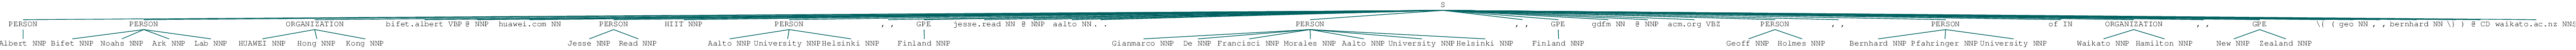

In [55]:
corpus['p59.pdf']['Entities']

# Testing/building individual compents happens below; then I paste it above

In [7]:
# Convert document from unicode to string 

import unicodedata
document = unicodedata.normalize('NFKD', a).encode('ascii','ignore')
document[:2500]

'Using TF-IDF to Determine Word Relevance in Document Queries \n\nJuan Ramos \nDepartment of Computer Science, Rutgers University, 23515 BPO Way, Piscataway, NJ, 08855 \n \n \n\nJURAMOS@EDEN.RUTGERS.EDU \n\nAbstract \n\nIn this paper, we examine the results of applying \nTerm  Frequency  Inverse  Document  Frequency \n(TF-IDF) to determine what words in a corpus of \ndocuments might be more favorable to use in a \nquery.    As  the  term implies, TF-IDF  calculates \nvalues for each word in a document through an \ninverse proportion of the frequency of the word \nin  a  particular  document  to  the  percentage  of \ndocuments  the  word  appears  in.    Words  with \nhigh  TF-IDF  numbers \nstrong \nrelationship  with  the  document  they  appear  in, \nsuggesting that if that word were to appear in a \nquery, the document could  be  of interest to the \nuser.    We  provide  evidence  that  this  simple \nalgorithm  efficiently  categorizes  relevant  words \nthat can enhance query r

In [8]:
# Getting title
title = re.findall("^[^\\n\\n]+",document)[0]
title

# Getting the abstract
abstract = re.findall (r'\n\n(Abstract|ABSTRACT)([^]]*)\n\n',document[:2000])[0]

if isinstance(abstract, tuple):
    abstract = re.sub('[\s]'," ",abstract[1])
else:
    abstract = re.sub('[\s]'," ",abstract)
abstract

'   In this paper, we examine the results of applying  Term  Frequency  Inverse  Document  Frequency  (TF-IDF) to determine what words in a corpus of  documents might be more favorable to use in a  query.    As  the  term implies, TF-IDF  calculates  values for each word in a document through an  inverse proportion of the frequency of the word  in  a  particular  document  to  the  percentage  of  documents  the  word  appears  in.    Words  with  high  TF-IDF  numbers  strong  relationship  with  the  document  they  appear  in,  suggesting that if that word were to appear in a  query, the document could  be  of interest to the  user.    We  provide  evidence  that  this  simple  algorithm  efficiently  categorizes  relevant  words  that can enhance query retrieval.   imply   a   1.  Introduction  Before  proceeding  in  depth  into  our  experiments,  it  is  useful  to  describe  the  nature  of  the  query  retrieval  problem  for  a  corpus  of  documents  and  the  different  app

In [9]:
# Extracts section with names and email addresses only

section  = re.findall (r'\n\n([^]]*)\n\n(Abstract|ABSTRACT)',document[:2000])

type(section[0][0])

if isinstance(section, list):
    section = re.sub('[\s]'," ",section[0][0])
else:
    section = re.sub('[\s]'," ",section)
section


'Juan Ramos  Department of Computer Science, Rutgers University, 23515 BPO Way, Piscataway, NJ, 08855       JURAMOS@EDEN.RUTGERS.EDU '

In [ ]:
test = re.findall (r'\n\n([^]]+)\n\n(Abstract|ABSTRACT)',document[:2000] )

if isinstance(test, str):
    print "Wow"
elif isinstance (test,int):
    print "I'm surprised!"

elif  isinstance (test,list):
    print "We got it RIGHT!"

else:
    print "Nothing fits"


In [16]:
# Code to extract entities from top section of pdf and store a relationship tree

import nltk

tagged = nltk.pos_tag(nltk.word_tokenize(section))
entities = nltk.chunk.ne_chunk(tagged)
entities.un_chomsky_normal_form

<bound method Tree.un_chomsky_normal_form of Tree('S', [Tree('PERSON', [('Juan', 'NNP')]), Tree('PERSON', [('Ramos', 'NNP'), ('Department', 'NNP')]), ('of', 'IN'), Tree('ORGANIZATION', [('Computer', 'NNP'), ('Science', 'NNP')]), (',', ','), Tree('ORGANIZATION', [('Rutgers', 'NNP'), ('University', 'NNP')]), (',', ','), ('23515', 'CD'), Tree('ORGANIZATION', [('BPO', 'NNP'), ('Way', 'NNP')]), (',', ','), Tree('GPE', [('Piscataway', 'NNP')]), (',', ','), Tree('ORGANIZATION', [('NJ', 'NNP')]), (',', ','), ('08855', 'CD'), Tree('ORGANIZATION', [('JURAMOS', 'NNP')]), ('@', 'NNP'), ('EDEN.RUTGERS.EDU', 'NNP')])>

In [20]:
# Use another entity extractor


from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
					   encoding='utf-8')

text = section
tokenized_text = word_tokenize(section)
classified_text = st.tag(tokenized_text)

print(classified_text)

[(u'Juan', u'ORGANIZATION'), (u'Ramos', u'ORGANIZATION'), (u'Department', u'ORGANIZATION'), (u'of', u'ORGANIZATION'), (u'Computer', u'ORGANIZATION'), (u'Science', u'ORGANIZATION'), (u',', u'O'), (u'Rutgers', u'ORGANIZATION'), (u'University', u'ORGANIZATION'), (u',', u'O'), (u'23515', u'O'), (u'BPO', u'MISC'), (u'Way', u'MISC'), (u',', u'O'), (u'Piscataway', u'LOCATION'), (u',', u'O'), (u'NJ', u'LOCATION'), (u',', u'O'), (u'08855', u'O'), (u'JURAMOS', u'O'), (u'@', u'O'), (u'EDEN.RUTGERS.EDU', u'O')]


In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print type(ENGLISH_STOP_WORDS)
print type(nltk.corpus.stopwords.words('english'))

In [ ]:
a= [l for l in ENGLISH_STOP_WORDS]
b = [l for l in nltk.corpus.stopwords.words('english')]

len(set(a) & set(b))

In [ ]:
# Creates the json document format to store the files

corpus = {}
corpus[str(fileName)]={}
corpus[str(fileName)]={'Title':title,'Abstract':abstract,'Entities':entities}
corpus['p99.pdf']={'Title':"Test title",'Abstract':"test abstract langauge.  Just adding test to make it longer", 'Entities':"Linwood Creekmore"}

corpus.keys()



In [25]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.muc.7class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-ner-3.5.2.jar',
					   encoding='utf-8')

st.tag(word_tokenize(section))

[(u'Juan', u'O'),
 (u'Ramos', u'ORGANIZATION'),
 (u'Department', u'ORGANIZATION'),
 (u'of', u'ORGANIZATION'),
 (u'Computer', u'ORGANIZATION'),
 (u'Science', u'ORGANIZATION'),
 (u',', u'O'),
 (u'Rutgers', u'ORGANIZATION'),
 (u'University', u'ORGANIZATION'),
 (u',', u'O'),
 (u'23515', u'O'),
 (u'BPO', u'O'),
 (u'Way', u'O'),
 (u',', u'O'),
 (u'Piscataway', u'LOCATION'),
 (u',', u'O'),
 (u'NJ', u'O'),
 (u',', u'O'),
 (u'08855', u'O'),
 (u'JURAMOS', u'O'),
 (u'@', u'O'),
 (u'EDEN.RUTGERS.EDU', u'O')]

In [31]:
from nltk.stem.wordnet import WordNetLemmatizer

full = re.sub('[\s]'," ", document)

In [34]:
# from http://brandonrose.org/clustering



from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()
wordnet_tags = ['n', 'v', 'a', 's', 'r']

def tokenize_and_stem_n_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    lems = [lemmer.lemmatize(l) for l in filtered_tokens]
    
    return stems,lems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens




NameError: name 'lems' is not defined

In [42]:
tokenize_and_stem_n_lem(abstract)[1];

['In',
 'this',
 'paper',
 'we',
 'examine',
 'the',
 u'result',
 'of',
 'applying',
 'Term',
 'Frequency',
 'Inverse',
 'Document',
 'Frequency',
 'TF-IDF',
 'to',
 'determine',
 'what',
 u'word',
 'in',
 'a',
 'corpus',
 'of',
 u'document',
 'might',
 'be',
 'more',
 'favorable',
 'to',
 'use',
 'in',
 'a',
 'query',
 'As',
 'the',
 'term',
 'implies',
 'TF-IDF',
 'calculates',
 u'value',
 'for',
 'each',
 'word',
 'in',
 'a',
 'document',
 'through',
 'an',
 'inverse',
 'proportion',
 'of',
 'the',
 'frequency',
 'of',
 'the',
 'word',
 'in',
 'a',
 'particular',
 'document',
 'to',
 'the',
 'percentage',
 'of',
 u'document',
 'the',
 'word',
 'appears',
 'in',
 'Words',
 'with',
 'high',
 'TF-IDF',
 u'number',
 'strong',
 'relationship',
 'with',
 'the',
 'document',
 'they',
 'appear',
 'in',
 'suggesting',
 'that',
 'if',
 'that',
 'word',
 'were',
 'to',
 'appear',
 'in',
 'a',
 'query',
 'the',
 'document',
 'could',
 'be',
 'of',
 'interest',
 'to',
 'the',
 'user',
 'We',
 'p

In [ ]:
import requests, unicodedata
text = urllib2.urlopen('http://www.constitution.org/cons/constitu.txt')
constitution = requests.get('http://www.constitution.org/cons/constitu.txt')

const = unicodedata.normalize('NFKD', constitution.text).encode('ascii','ignore')
type(const)

In [ ]:
text = ' '.join(re.findall('[\w]+',const))
type(text)

In [ ]:
from os import path
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# read the mask / color image
# taken from http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
from PIL import Image
import requests
from StringIO import StringIO

response = requests.get("http://www.personal.psu.edu/sdh5174/Mario_png.png")

mario_coloring = np.array(Image.open(StringIO(response.content)))

wc = WordCloud(background_color="white", max_words=2000, mask=mario_coloring,
               stopwords=STOPWORDS.add("said"),
               max_font_size=40, random_state=42)
# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mario_coloring)

# show
plt.imshow(wc)
plt.axis("off")
plt.figure()
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis("off")
plt.figure()
plt.imshow(mario_coloring, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [ ]:
from statsmodels.datasets import cancer
import statsmodels.api as sm

In [ ]:
data = sm.datasets.get_rdataset("Duncan", "car")

In [ ]:
data

In [ ]:
print data.__doc__

In [ ]:
sm.

In [ ]:
import statsmodels.api as sm
air = sm.datasets.get_rdataset("airquality")

In [ ]:
type(air.data)

In [ ]:
air.data.describe()